Project: Advanced Load Modeling (ALM)

Author: Mohamed Nijad

Advisor: David P. Chassin

Date: March 2022

# Introduction

This notebook documents the development of the ALM load models, which uses different approches to predict load based on time, date, and temperature, and to estimate the dynamic response of the aggregate load demand of all the buildings on a feeder to various changes in conditions based on historical measurement of feeder load, outdoor air temperature, and solar gains. 

The following python packages are required. 

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sy
import models   # from advanced load modeling file
import control as ct  
from datetime import *
from dateutil import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Modeling Methodology

**Problem:** Predict load based on time, date, and weather.

#### Approches considered:

1. Static Model (Predict load based on current weather only)
 - P =  *F(heat index [0], solar_index[0])*


2. Dynamic Model (Predict load based on recent load and weather)
 - P = *G(Power[1:N], heat_index[0:N], solar_index[0:N])*
    
    
3. Hyprid Model (Static model + Dynamic residual model)
 - P = *F(heat_index[0], solar_index[0]) + G(Power[1:N] - F(heat_index[0], solar_index[0]), heat_index[0:N], solar_index[0:N])*
                    
***
        

## Loading Data

#### Load feeder data (read_power_file)

*Inputs:*
- **power_file_csv (str):**        input csv file name for feeder data (example.csv)
- **datetime_col_name (str):**      input column name for datetime data
- **power_col_name (str):**         input column name for power data
- **DatetimeFormat (str):**         input datetime format (defult format "%m/%d/%y %H:%M")

*Returns:*
-  **Power DataFrame:** hourly power data with datetime index 

#### Load weather data (read_weatherfile)
*Inputs:*
- **weather_file_csv (str):**       input csv file name for feeder data (example.csv)
- **datetime_col_name (str):**      input column name for datetime data
- **temperature_col_name (str):**   input column name for temperature data (degF)
- **solar_col_name (str):**         -OPTIONAL- input column name for solar index data (W/defF)
- **DatetimeFormat (str):**         input datetime format (defult format "%m/%d/%y %H:%M")

*Returns:*
-  **Weather DataFrame:** Temperature and Solar gain (if provided) data with datetime index 

*Check read_power_file and read_weather_file in models python file for detailed implementation


In [2]:
# User input (power and weather csv files)
power = models.read_power_file('feeder_power.csv','timestamp','feeder_power')
weather = models.read_weatherfile('feeder_weather.csv', 'datetime', 'heat_index[degF]', 'solar_global[W/sf]',
                        DatetimeFormat = '%Y-%m-%d %H:%M:%S')
feeder = weather.join(power).dropna()
feeder

,solar,temperature,power
datetime,,,
2014-10-01 00:00:00,0.0,47.8,1747.5
2014-10-01 01:00:00,0.0,47.8,1669.7
2014-10-01 02:00:00,0.0,47.8,1621.8
2014-10-01 03:00:00,0.0,47.8,1629.3
2014-10-01 04:00:00,0.0,47.8,1692.5
...,...,...,...
2017-09-30 19:00:00,0.0,49.7,2205.2
2017-09-30 20:00:00,0.0,49.7,2151.1
2017-09-30 21:00:00,0.0,49.7,2060.0


# Static Model 

This section runs the static model given historic power and weather data (feeder dataframe).

*Check get_baseload and get_slopes functions in models python file for detailed implementation.


In [3]:
# User input (Tbase and Tdiff)
# Static model configuration
Tbase = 'auto'    # Tbase = 'auto' minimize slope of base. Otherwise, specify Tbase
Tdiff = 10        # Temperature difference between Theat and Tcool (base region) defult is 10degF

In [4]:
# Get information for base model (Tbase +- 5degF)
slope_base, Tbase, base, intercept = models.get_baseload(feeder, Tbase, Tdiff)

# Determining slopes for heating and cooling regions
Theat = Tbase - Tdiff/2                         #determines Theat based on Tbase and Tdiff
Tcool = Tbase + Tdiff/2                         #determines Tcool based on Tbase and Tdiff
heating = feeder[feeder.temperature < Theat]   
cooling = feeder[feeder.temperature > Tcool]

heat_slope, cool_slope, h0, c0 = models.get_slopes(heating,cooling)

# Extends feeder dataframe to include static power (P_static)
feeder["P_static"] = np.nan
feeder.loc[feeder['temperature'] < Theat, 'P_static'] =  h0 + heat_slope*feeder['temperature']
feeder.loc[feeder['temperature'] > Tcool, 'P_static'] =  c0 + cool_slope*feeder['temperature']
feeder.loc[(feeder['temperature']-Tbase).abs()<=Tdiff/2, 'P_static'] =  intercept + slope_base*feeder['temperature']

Plotting static model

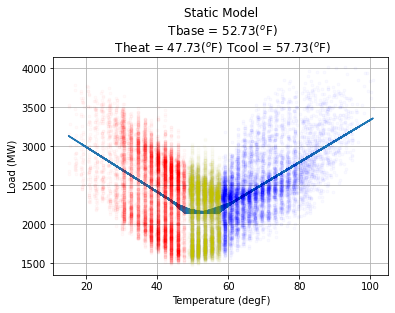

In [5]:
plt.plot(feeder.temperature, feeder.P_static)
plt.plot(heating.temperature,heating.power,'.r', alpha=0.02)
plt.plot(cooling.temperature,cooling.power,'.b', alpha=0.02)
plt.plot(base.temperature,base.power,'.y', alpha=0.02)
plt.xlabel('Temperature (degF)')
plt.ylabel('Load (MW)')
plt.title(f'Static Model\n Tbase = {Tbase:.2f}($^o$F)\n Theat = {Theat:.2f}($^o$F) Tcool = {Tcool:.2f}($^o$F)')
plt.grid()
plt.show()

# Dynamic Model

The $z$-domain transfer function from $T$ to $P$ can be written as
$$
    { P(z) \over T(z) } = { b_0 + b_1 z^{-1} + b_2 z^{-2} + b_3 z^{-3} \over 1 + a_1 z^{-1} + a_2 z^{-2}+ a_3 z^{-3} }
$$
which gives us the relation
$$
    \mathbf{P}_{t} = b_3 \mathbf{T}_{t-3} + b_2 \mathbf{T}_{t-2} + b_1 \mathbf{T}_{t-1} + b_0 \mathbf{T}_{t} - a_3 \mathbf{P}_{t-3} - a_2 \mathbf{P}_{t-2} - a_1 \mathbf{P}_{t-1}
$$
where $t \in (L,K)$, and $\mathbf P$ and $\mathbf T \in \mathbb{R}^{K}$.

Given $K$ samples of power and temperature, and $N$ model order, this can be written in the form
$$
     \mathbf{P}_{t} = \mathbf{M} \mathbf{x}
$$
where $\mathbf{M} \in \mathbb{R}^{K-N\times (2N +1)}$ with
$$
    \mathbf{M} = \left[ \begin{matrix} \mathbf{P}_{t-N} ... \mathbf{P}_{t-2} & \mathbf{P}_{t-1} & \mathbf{T}_{t-N}... \mathbf{T}_{t-2} & \mathbf{T}_{t-1} & \mathbf{T}_{t} \end{matrix} \right]
$$
and
$$
    \mathbf{x} = \left[ \begin{matrix} a_N... a_2 & a_1 & b_N... b_2 & b_1 & b_0 \end{matrix} \right]^T
$$

If solar gains data is given as well, model can include solar data to improve prediction, this will be written as
$$
    \mathbf{M} = \left[ \begin{matrix} \mathbf{P}_{t-N}...\mathbf{P}_{t-2} & \mathbf{P}_{t-1} & \mathbf{T}_{t-N} ...\mathbf{T}_{t-2} & \mathbf{T}_{t-1} & \mathbf{T}_{t} & \mathbf{S}_{t-N}... \mathbf{S}_{t-2} & \mathbf{S}_{t-1} & \mathbf{S}_{t} \end{matrix} \right]
$$
and
$$
    \mathbf{x} = \left[ \begin{matrix} a_N... a_2 & a_1 & b_N... b_2 & b_1 & b_0 & c_N... c_2 & c_1 & c_0 \end{matrix} \right]^T
$$


Solve for $\mathbf x$
$$
    \mathbf{x} = (\mathbf{M}^T \mathbf{M})^{-1} \mathbf{M}^T \mathbf{P}_{t}.
$$

***

### Model parameters:

*Inputs:*
-  **dataframe (DataFrame):**           dataset for feeder power, temperature, and optional solar with datetime index
-  **mode ('dynamic' or 'hyprid'):**    model mode (default "dynamic")
-  **months_div (2,3,4,6,12 or 'auto'):**      months divisor in a year
- **days_div (2,7 or 'auto'):**               days divisor in a week
- **hours_div (2,3,4,6,8,12,24 or 'auto'):**  hours divisor in a day
- **holdout_data (decimal):**                 fraction of data held for testing       
- **model_order (int):**                      Model order

*Returns:*
- **Figure 1:** Error plot with printed mean of error % and standard deviation.
- **Figure 2:** Power plot as a function of time for model vs. actual data. 
- **Figure 3-1:** Power plot as a function of temperature for model vs. actual data.
- **Figure 3-2:** Power plot as a function of solar gains for model vs. actual data.
- **Model Parameters used for fitting:**
     1. Months divisor
     2. Days divisor
     3. Hours divisor
     4. Model order
     5. Hold out data
  
  
- **Transfer function:** power to temperature

*Check models python file for all support functions for dynamic_model function



#### Loading Model :
This section shows the dynamic model applied to the total load.


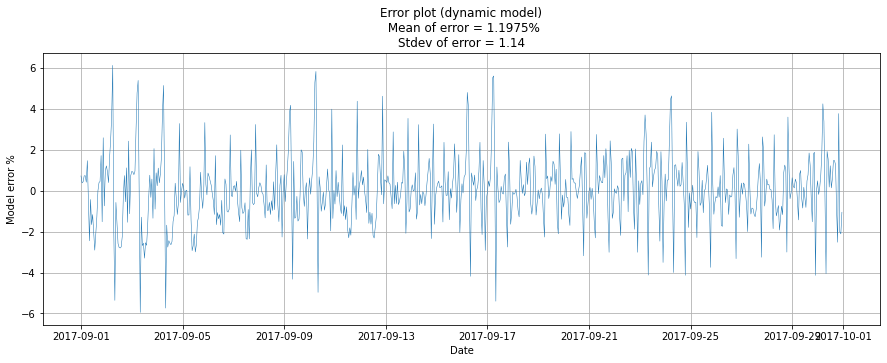

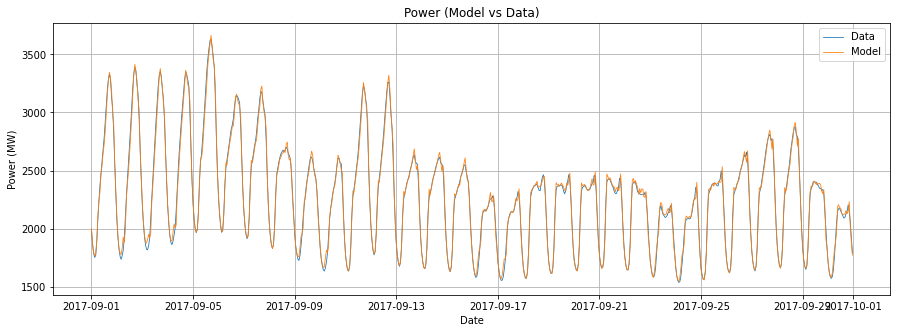

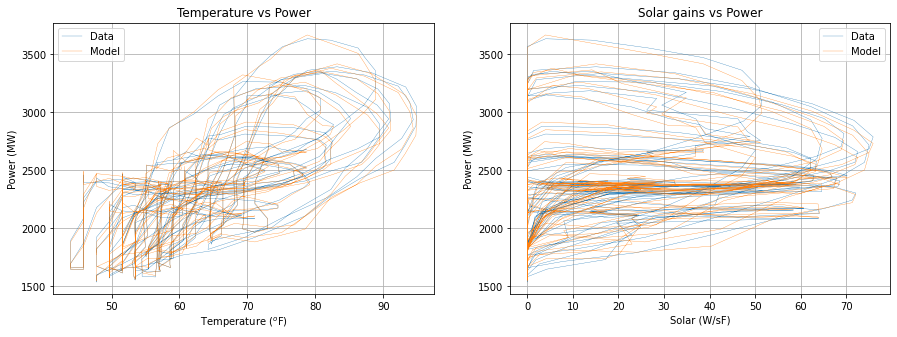

MODEL PARAMETERS
Months divisor: 1
Days divisor: 1
Hours divisor: 24
Model order: 3
Hold out data fraction: 0.0275


TransferFunction(array([-1.36003805,  3.12167903, -1.89036418, -0.21081554]), array([ 0.28084242, -1.0913608 ,  1.78772696]), 1)

In [43]:
models.dynamic_model(feeder,mode = 'dynamic', model_order = 3)

# Hyprid Model

This section runs the runs the hyprid model given historic load and weather data (feeder dataframe)

1. Run the static model to get the static power
2. Compute residual power by removing static from total power 
     $$ \mathbf{P}_{residual} = \mathbf{P}_{total} - \mathbf{P}_{static}   $$
3. Fit resdiual power on dynamic model then add back static power

In [7]:
# Residual power computed from total and staic power and added to the feeder dataframe
feeder["P_residual"] = np.nan
feeder.loc[:,'P_residual'] = feeder['power'] - feeder['P_static']

Fit residual power on dynamic model by running mode = 'hyprid'

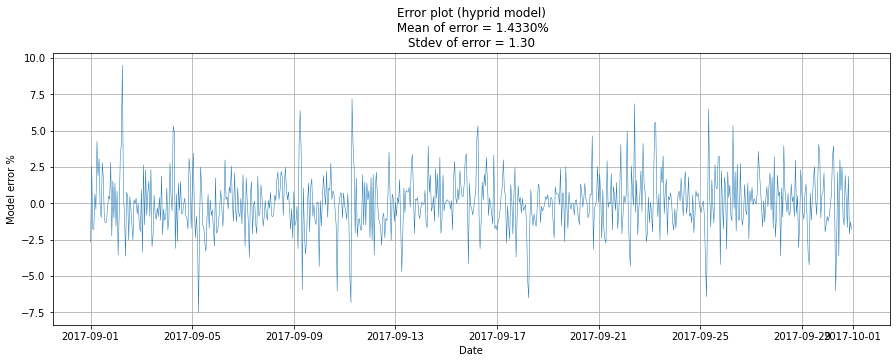

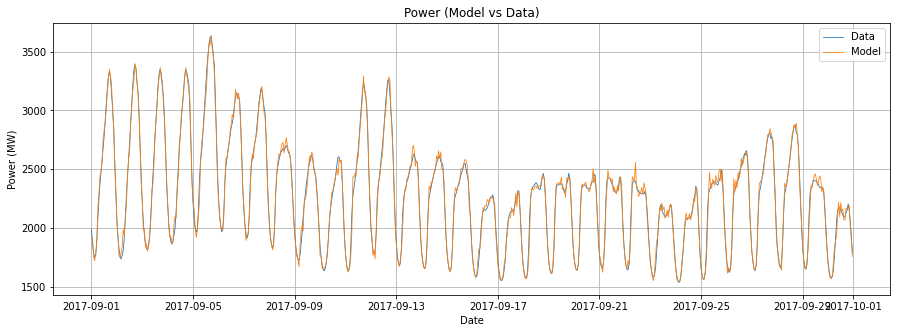

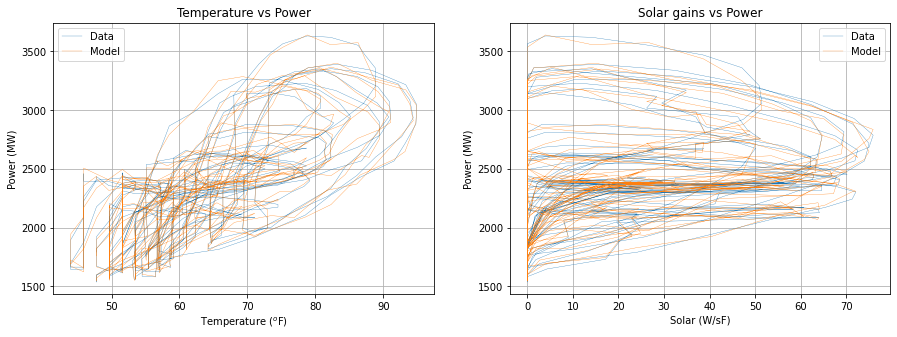

MODEL PARAMETERS
Months divisor: 6
Days divisor: 2
Hours divisor: 8
Model order: 27
Hold out data fraction: 0.0275


TransferFunction(array([ 0.2728958 , -0.38118801,  1.1342998 , -0.87796747, -1.00746065,
        0.34121806,  0.41744291, -0.74394977,  0.48002914,  0.33227536,
       -1.10857639,  0.55898025,  0.04276079,  0.16875212, -0.36067085,
       -0.3932432 ,  0.58926061, -0.48383282,  0.52194137, -0.73645127,
        0.14135842, -0.40848764, -0.19337045,  1.82244642,  1.07359559,
        1.71287612, -4.08472936,  1.16479063]), array([ 0.05956458,  0.00551803, -0.41232769,  0.25918886,  0.19169126,
       -0.04775755, -0.01406119, -0.01123889,  0.01759624,  0.01615835,
       -0.01198722,  0.03717932, -0.05429144,  0.00345889,  0.00355398,
       -0.01210932, -0.0108134 ,  0.04576174,  0.00305319,  0.02987565,
       -0.05767739, -0.00292917, -0.01193647, -0.01421456,  0.06722539,
       -0.47316136,  1.32593136]), 1)

In [44]:
models.dynamic_model(feeder,mode='hyprid')

# Forecaster

### Forecaster parameters:

*Inputs:*

- **dataframe (DataFrame):**              data set for feeder power and temperature with datetime index
- **t0 (datetime(year,month,day,hour)):** date and hour to start forcasting 
- **hours (int):**  number of hours to forecast ahead of t0
- **mode ('hyprid'or'dynamic'):**           get power from hyprid or dynamic model

*Returns:*
- **result (DataFrame):**    dataframe with forecast load for the specified time frame with datetime index 
        
*Check forecast function in models python file for detailed implementation.


In [9]:
# User input  
t0 = datetime(2017,8,1,12)  #(year, month, day, hour)
hours = 24            

In [10]:
#Calling forecast function
R = models.forecast(feeder, t0,hours,mode = 'hyprid').join(feeder.power).join(feeder.P_static).join(feeder.P_residual)
R1= models.forecast(feeder, t0,hours,mode = 'dynamic')

Plotting forecast for static, dynamic, and hyprid models

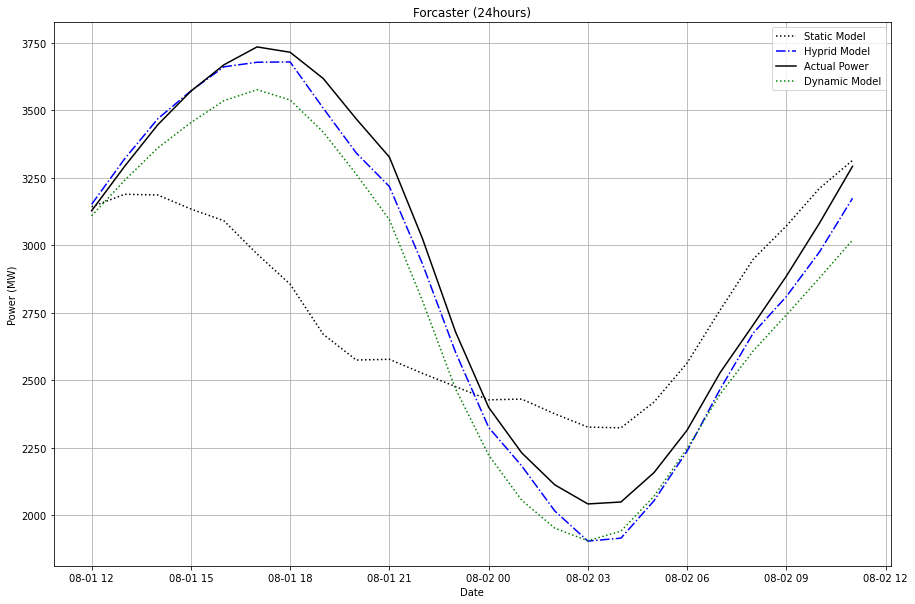

In [11]:
# plotting forecast
plt.figure(3,figsize = (15,10))
plt.plot(R.index,R.P_static , ':k', label = 'Static Model')
plt.plot(R.index,(R.P_static+R.forecast), '-.b',label = 'Hyprid Model')
plt.plot(R.index,R.power, 'k', label = 'Actual Power')
plt.plot(R1.index,R1.forecast, ':g',label = 'Dynamic Model')
plt.xlabel("Date")
plt.ylabel("Power (MW)")
plt.title("Forcaster (24hours)")
plt.grid()
plt.legend()
plt.show()